In [198]:
import numpy as np
from sklearn.base import clone
import random 
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from sklearn.ensemble import BaggingRegressor
from sklearn import decomposition
import math

In [3]:
tur = pd.read_csv("TURKANA_ANOMALIES.csv").set_index(["Unnamed: 0.1"])
nar = pd.read_csv("NAROK_ANOMALIES.csv").set_index(["Unnamed: 0.1"])
tur.name = 'tur'
nar.name = "nar"

In [4]:
tur = tur.rename(columns={'NDVI_anomaly': 'NDVI_z_score'})
nar = nar.rename(columns={'NDVI_anomaly': 'NDVI_z_score'})

In [23]:
tur["NDVI_dist"] = tur["NDVI_value"] - tur["mean_NDVI"]
nar["NDVI_dist"] = nar["NDVI_value"] - nar["mean_NDVI"]

In [63]:
# pull out egative and positive anomalies
tur_neg = tur[tur["NDVI_z_score"] > 0]
nar_neg = nar[nar["NDVI_z_score"] > 0]
tur_pos = tur[tur["NDVI_z_score"] < 0]
nar_pos = nar[nar["NDVI_z_score"] < 0]

tur_neg.name = "tur_neg"
nar_neg.name = "nar_neg"
tur_pos.name = "tur_pos"
nar_pos.name = "nar_pos"

In [123]:
tur_big_pos = tur[tur["NDVI_z_score"] > 1]
nar_big_pos = nar[nar["NDVI_z_score"] > 1]
tur_big_neg = tur[tur["NDVI_z_score"] < -1]
nar_big_neg = nar[nar["NDVI_z_score"] < -1]

In [124]:
tur_big_pos.name = "tur_big_pos"
tur_big_neg.name = "tur_big_neg"
nar_big_pos.name = "nar_big_pos"
nar_big_neg.name = "nar_big_neg"

In [163]:
def subset_by_rain(df): 
    rain_quantile = [df['sum_ppt'].quantile(q=.25), df['sum_ppt'].quantile(q=.5), 
                     df['sum_ppt'].quantile(q=.75)]
    q1_rain = df[df['sum_ppt']<=rain_quantile[0]]
    q2_rain = df[(df['sum_ppt']>rain_quantile[0]) & (df['sum_ppt']<rain_quantile[1])]
    q3_rain = df[(df['sum_ppt']>rain_quantile[1]) & (df['sum_ppt']<rain_quantile[2])]
    q4_rain = df[df['sum_ppt']>=rain_quantile[2]]
    
    q1_rain.name = df.name + "_q1_rain"
    q2_rain.name = df.name + "_q2_rain"
    q3_rain.name = df.name + "_q3_rain"
    q4_rain.name = df.name + "_q4_rain"
    return (q1_rain, q2_rain, q3_rain, q4_rain) 

In [189]:
# create datasets - 48 in total 
#base sets are samples and merged anomaly sets
# train test split Q1
# dfs= (tur_pos, tur_neg, nar_pos, nar_neg)
dfs= (tur_big_pos, tur_big_neg, nar_big_pos, nar_big_neg)

t_pos_train, t_pos_test = train_test_split(dfs[0], test_size = .2)
t_neg_train, t_neg_test = train_test_split(dfs[1], test_size = .2)
n_pos_train, n_pos_test = train_test_split(dfs[2], test_size = .2)
n_neg_train, n_neg_test = train_test_split(dfs[3], test_size = .2)

# # name dataframes
# t_pos_train.name = "t_pos_train"
# t_pos_test.name = "t_pos_test"
# n_pos_train.name = "n_pos_train"
# n_pos_test.name = "n_pos_test"
# t_neg_train.name = "t_neg_train"
# t_neg_test.name = "t_neg_test"
# n_neg_train.name = "n_neg_train"
# n_neg_test.name = "n_neg_test"

# name dataframes
t_pos_train.name = "t_big_pos_train"
t_pos_test.name = "t_big_pos_test"
n_pos_train.name = "n_big_pos_train"
n_pos_test.name = "n_big_pos_test"
t_neg_train.name = "t_big_neg_train"
t_neg_test.name = "t_big_neg_test"
n_neg_train.name = "n_big_neg_train"
n_neg_test.name = "n_big_neg_test"

# dfs = (tur, nar)
# tur_train, tur_test = train_test_split(dfs[0], test_size = .2)
# nar_train, nar_test = train_test_split(dfs[1], test_size = .2)
# tur_train.name = "tur_train"
# tur_test.name = "tur_test"
# nar_train.name = "nar_train"
# nar_test.name = "nar_test"

#use the full set
# base_sets = [tur, nar]
# base_sets = [tur_neg, tur_pos, nar_neg, nar_pos]
base_sets = [tur_big_neg, tur_big_pos, nar_big_neg, nar_big_pos]

#create train and test sets for the regression
train_sets = [t_pos_train, t_neg_train, n_pos_train, n_neg_train]
test_sets = [t_pos_test, t_neg_test, n_pos_test, n_neg_test]
# train_sets = [t_big_pos_train, t_big_neg_train, n_big_pos_train, n_big_neg_train]
# test_sets = [t_big_pos_test, t_big_neg_test, n_big_pos_test, n_big_neg_test]
# train_sets = [tur_train, nar_train]
# test_sets = [tur_test, nar_test]

#soil variable depths to consider
depths = ["30", '60', '100']
# land use to consider
lulc = ['cropland','grassland', 'shrub', 'trees']

#dictionary of dataframe name and dataframe - FULL DATA
def get_dataframes(base_sets):
    powerset_df = []
    powerset_all_depths = []
    for df in base_sets:
        for l in lulc:
            minus_lulc_cols = [col for col in df.columns if col not in lulc and col not in ['Unnamed: 0', 'Date']]
            lulc_name = (df.name + "_"+ l)
            lulc_df = df[df[l]>0][minus_lulc_cols]
#             lulc_df = df[df[l]==0][minus_lulc_cols]
            lulc_df.name = lulc_name
            powerset_all_depths.append(lulc_df)

            for depth in depths: 
                outdf_name = (df.name +"_"+ depth +"_"+ l)
                #pull appropriate soil columns
                select_cols = [col for col in df.columns if depth in col]
                #add back other columns needed
                select_cols.extend(['sum_ppt', 'mean_ppt', 'max_ppt', 'min_ppt',
                                    'median_ppt', 'std_ppt', 'days_of_rain', "NDVI_dist", 'NDVI_z_score', "mean_NDVI", "NDVI_value", "stdv_NDVI"])
                #subset the original dataframe
                good2go = df[df[l]>0][select_cols]
                good2go.name = outdf_name
                powerset_df.append(good2go)
                
    return (powerset_df, powerset_all_depths)

# get full datasets
powerset_df, powerset_all_depths = get_dataframes(base_sets)
# get train and test datasets
powerset_df_train, powerset_all_depths_train = get_dataframes(train_sets)
powerset_df_test, powerset_all_depths_test = get_dataframes(test_sets)

## Descriptive Statistics

In [205]:
# texture histograms
for df in [tur, nar]:
    depth = ["30", "60", "100"]
    tex = ["sand", "silt", "clay"]
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,9))
    for d in range(len(depth)): 
        for t in range(len(tex)):
            col = [col for col in df.columns if depth[d] in col and tex[t] in col]
            axs[d, t].hist(df[col]/1000, bins = 30)    
    axs[0,0].set_ylabel("30cm")
    axs[1,0].set_ylabel("60cm")
    axs[2,0].set_ylabel("100cm")
    axs[0,0].set_title("sand")
    axs[0,1].set_title("silt")
    axs[0,2].set_title("clay")
    axs[0,0].set_xlabel("percentage")
    axs[0,1].set_xlabel("percentage")
    axs[0,2].set_xlabel("percentage")
    # plt.tight_layout()
    plt.suptitle(((df.name).replace("_", " ") + " soil texture histograms"))  
    plt.savefig(("F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\Descriptive_stats\\soil_tex_hist\\" + df.name + "_soil_hist.jpg"))
    plt.close()

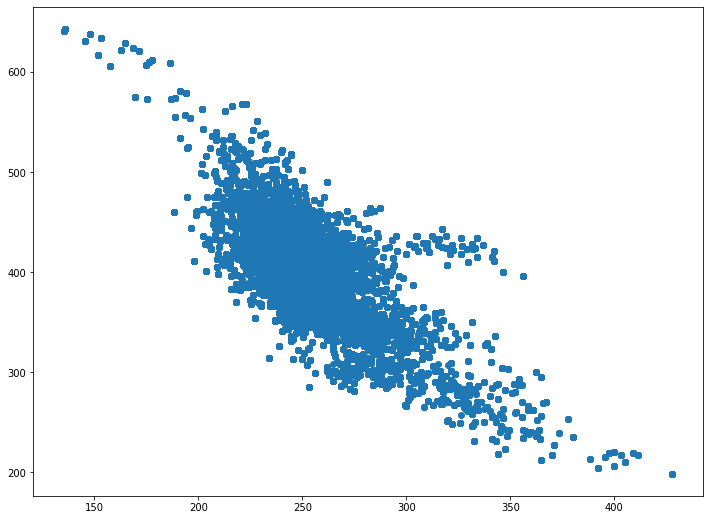

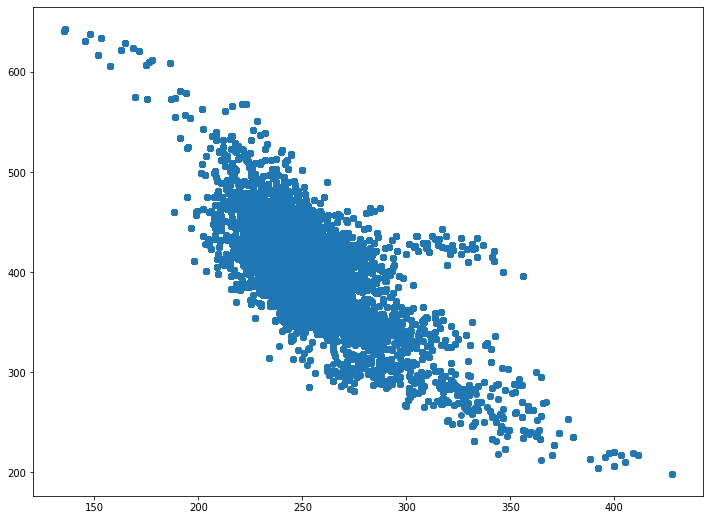

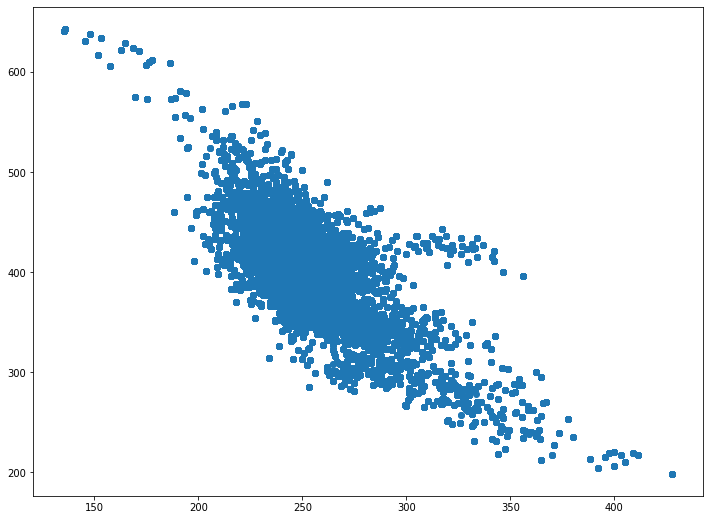

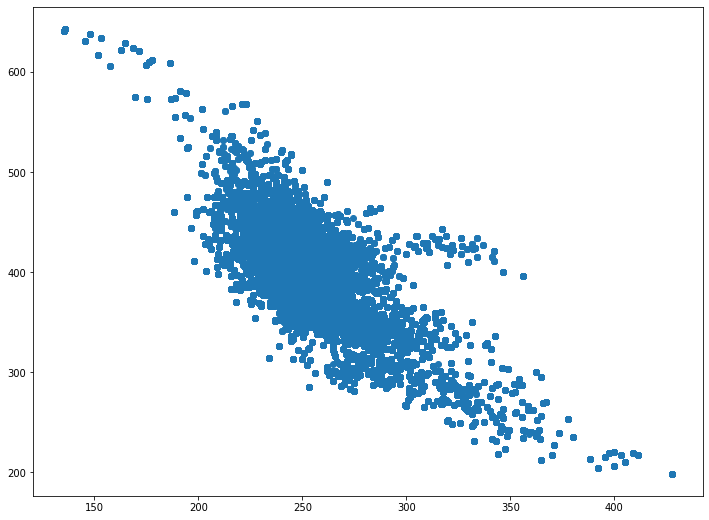

In [162]:
# pairplots
rain_dfs = subset_by_rain(powerset_df[0])
for df in rain_dfs:
    plt.subplots(figsize=(12,9))
    sand = [col for col in df.columns if "sand" in col]
    silt = [col for col in df.columns if "silt" in col]
    plt.scatter(df[silt], df[sand])
#     plt.title(("silt vs NDVI z_score" + (df.name).replace("_", " ")), fontsize = 16)
    plt.show()
#     file_path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\Descriptive_stats\\pairplots\\" + "pairplot_sand_NDV_val_" + df.name + ".jpg"
#     plt.savefig(file_path)

C:\Users\colorado\.conda\envs\research_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


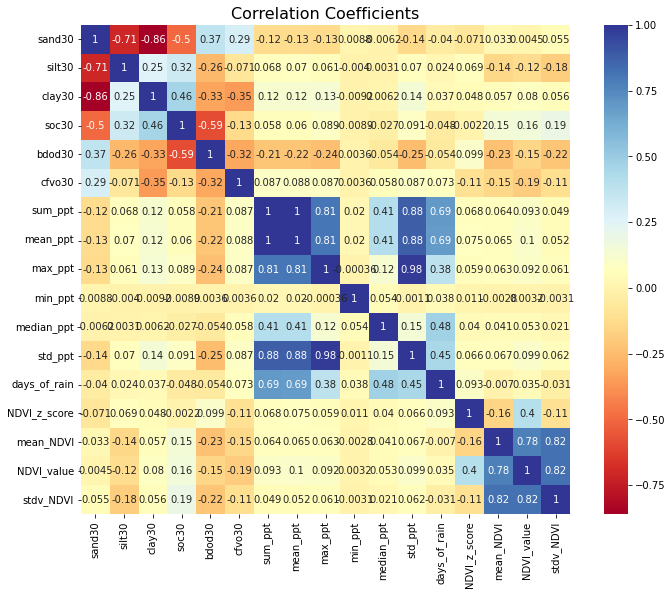

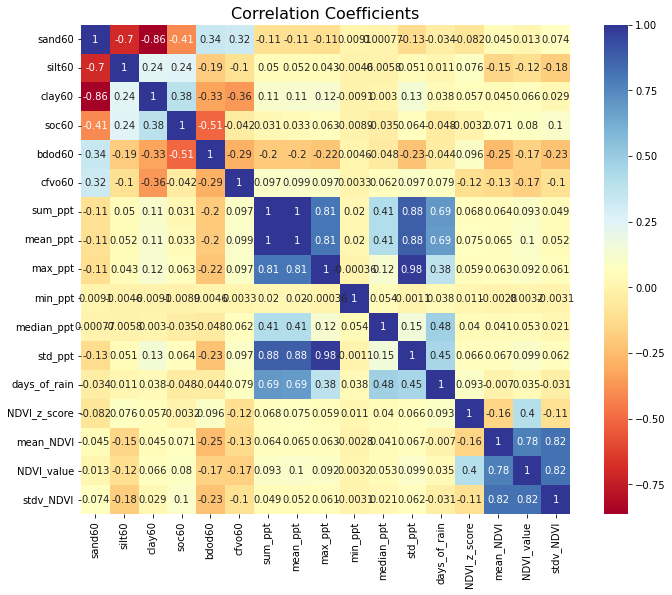

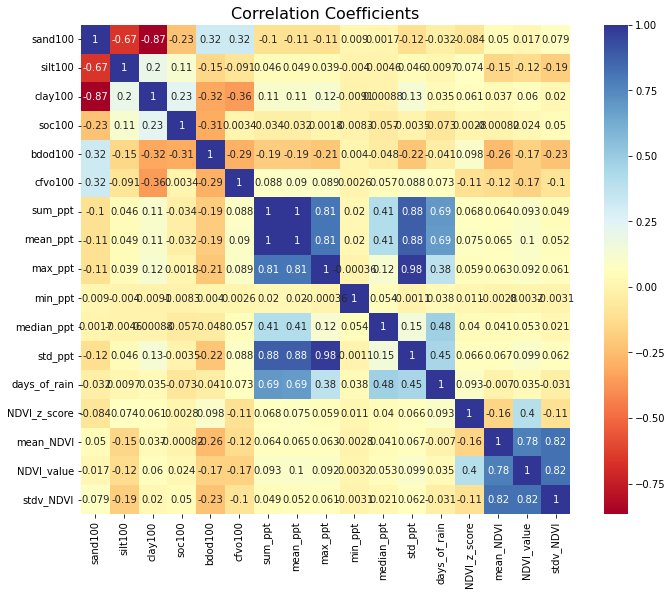

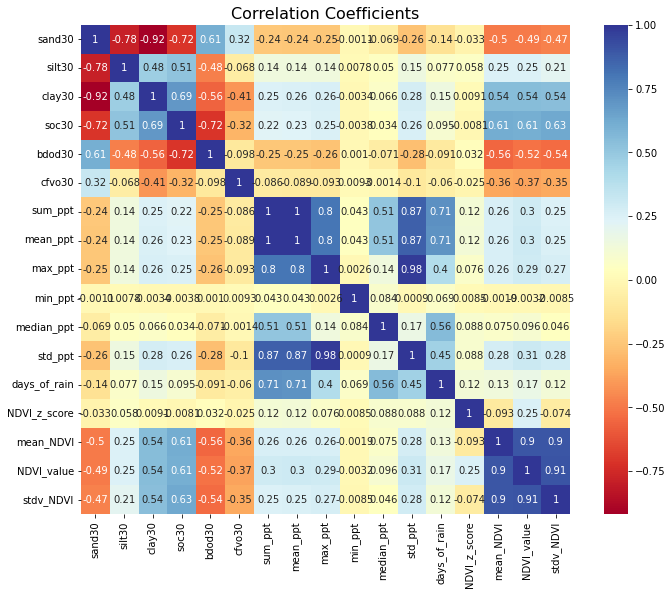

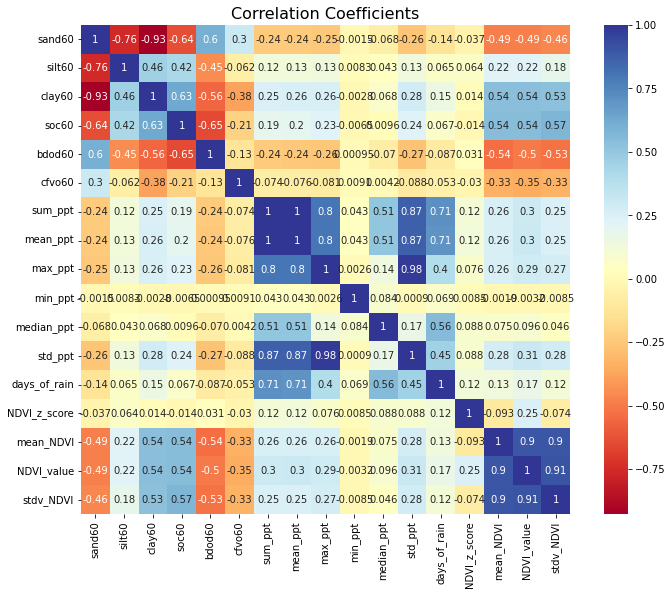

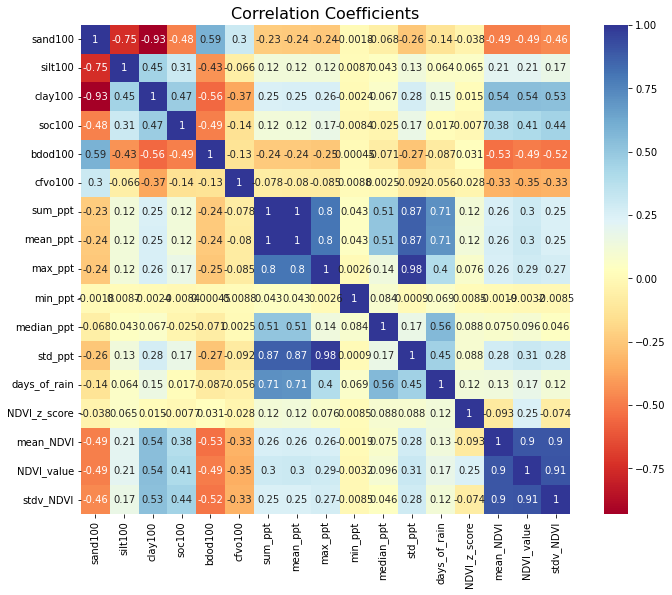

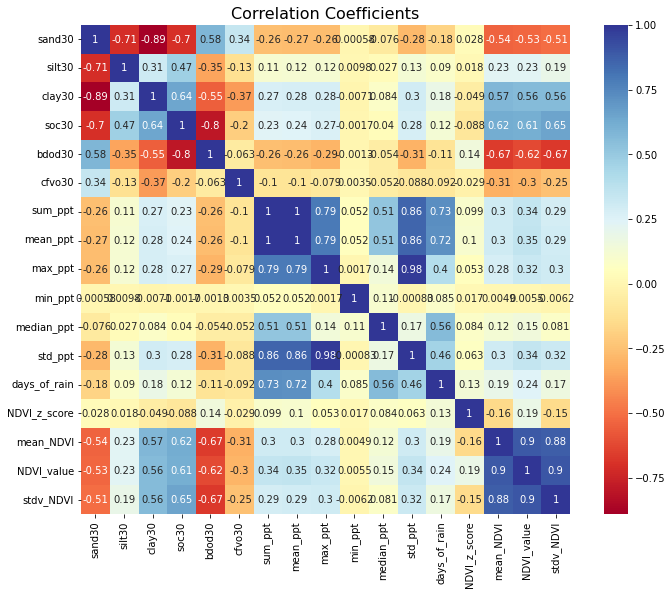

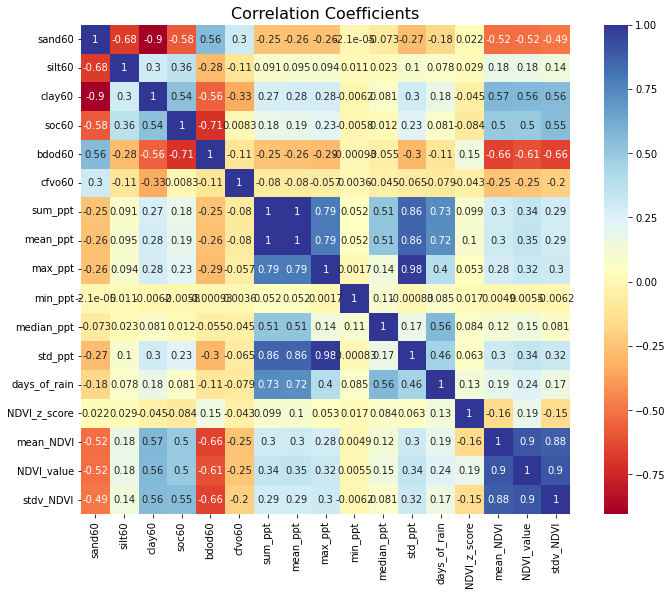

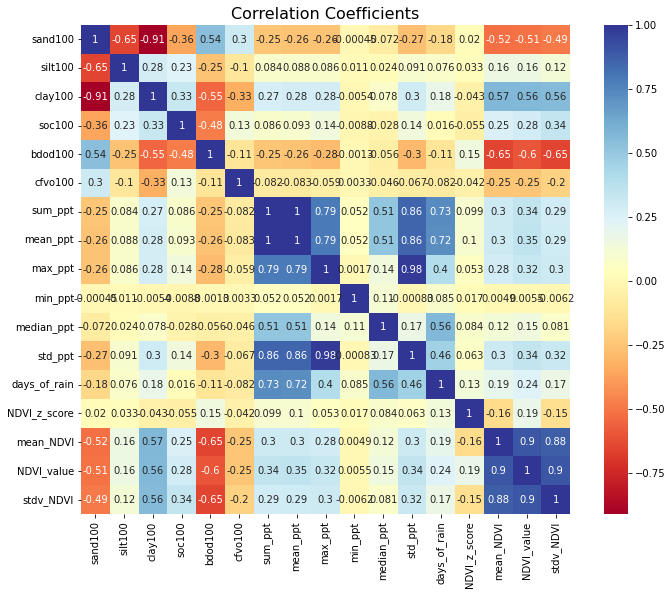

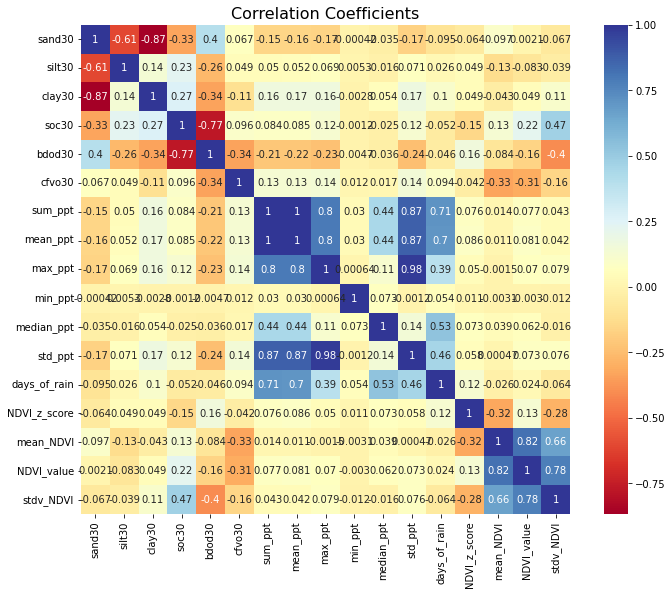

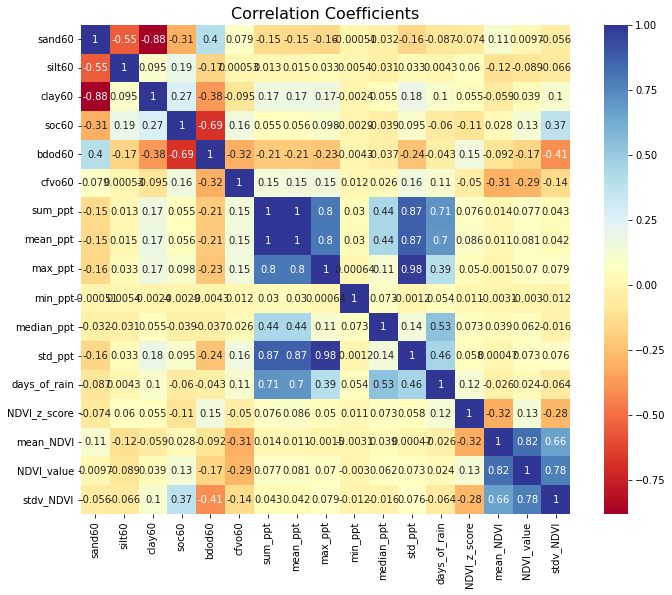

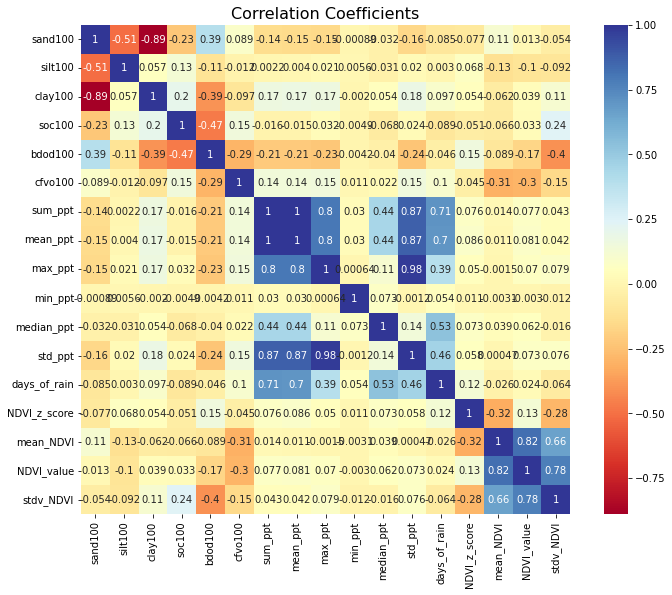

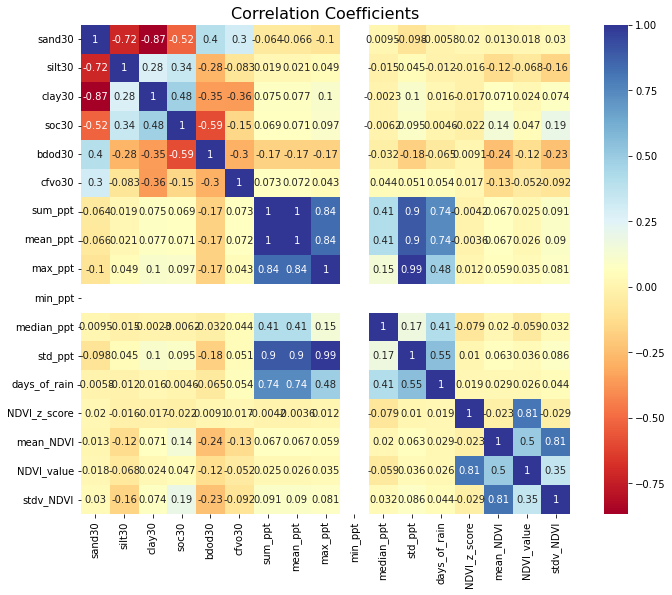

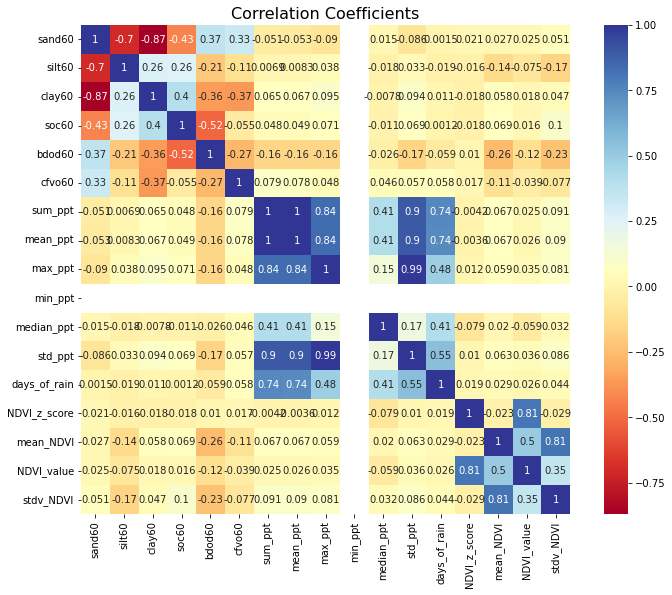

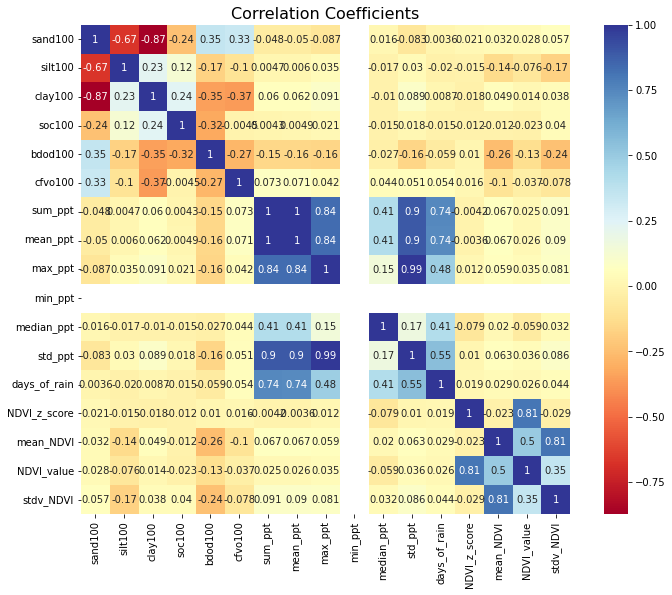

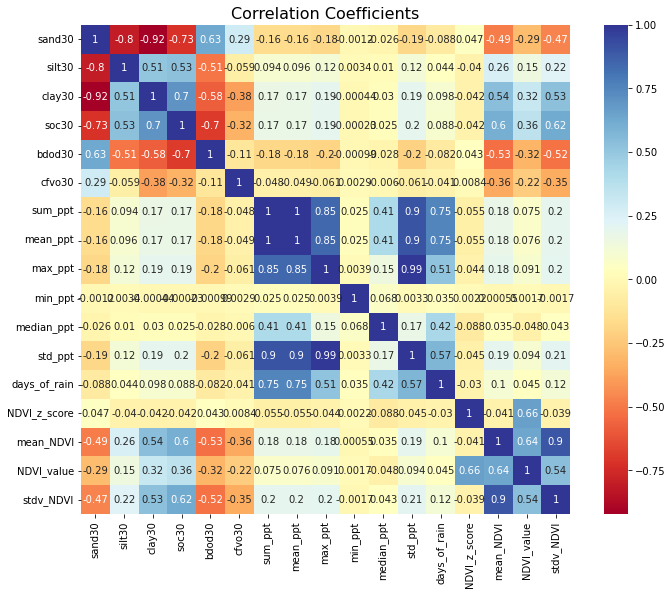

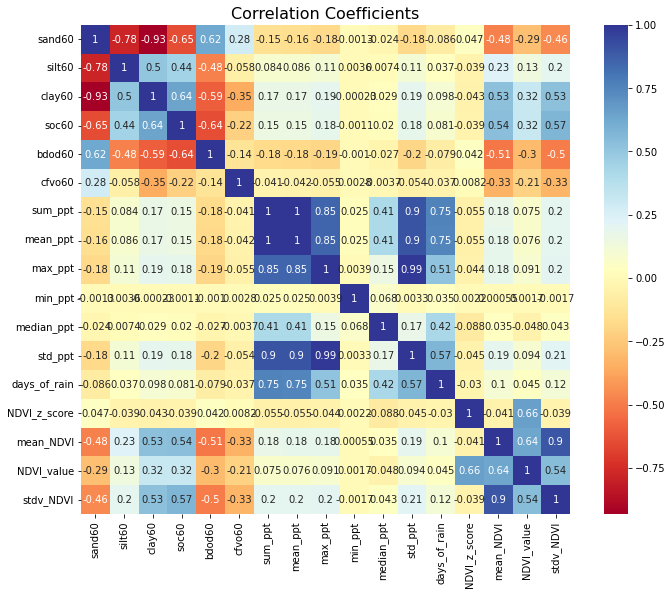

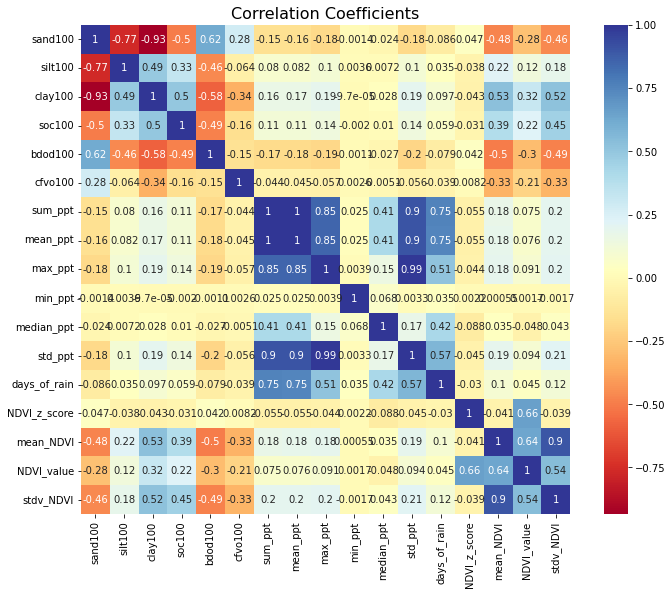

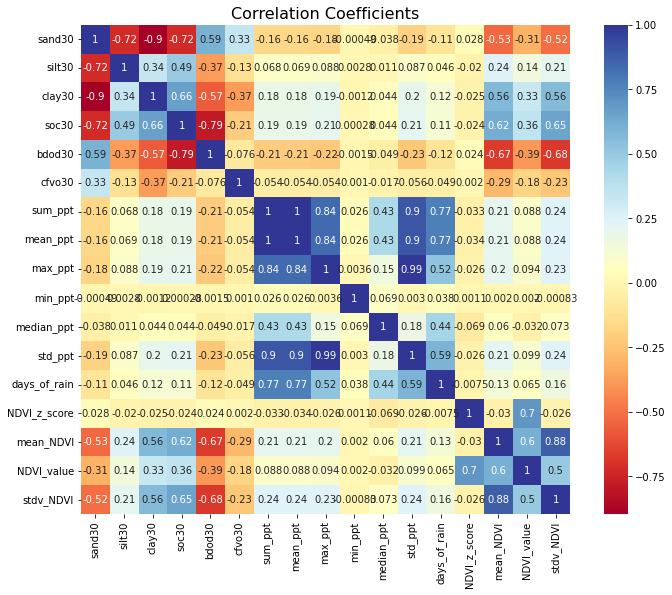

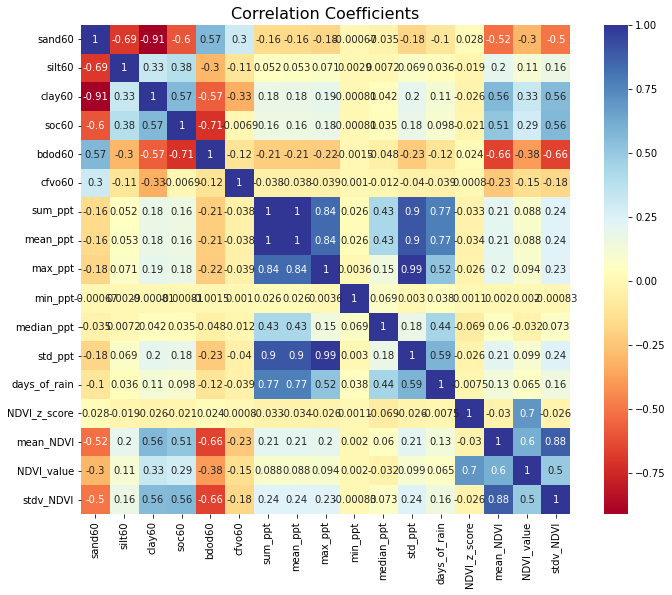

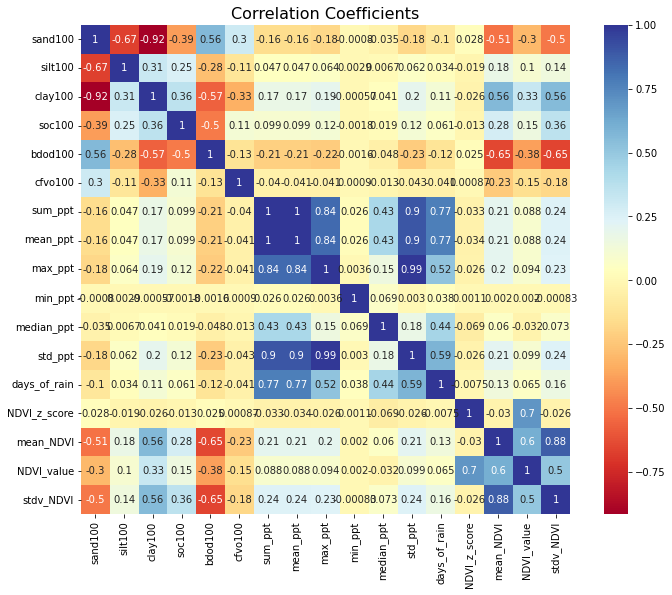

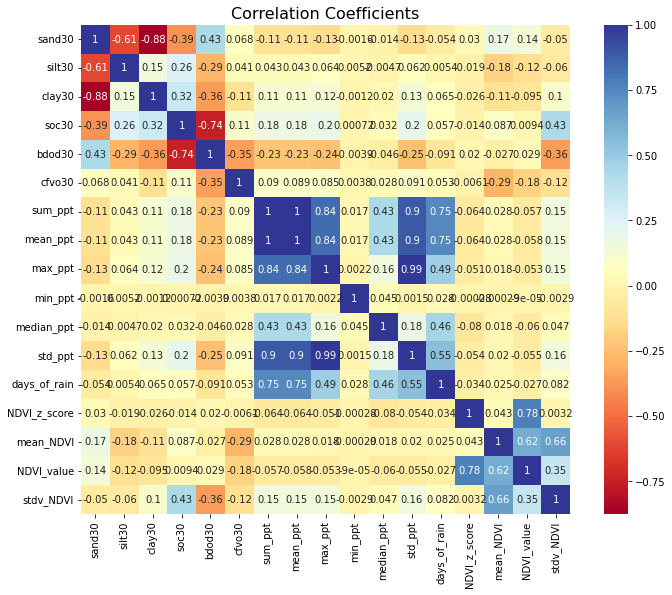

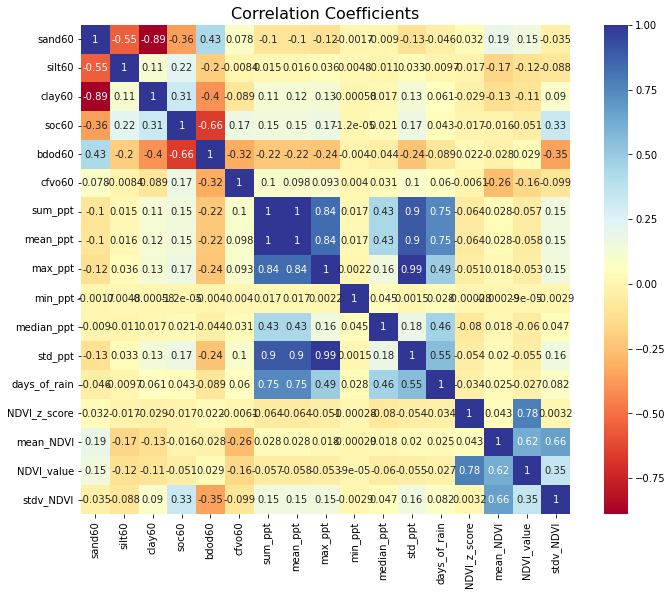

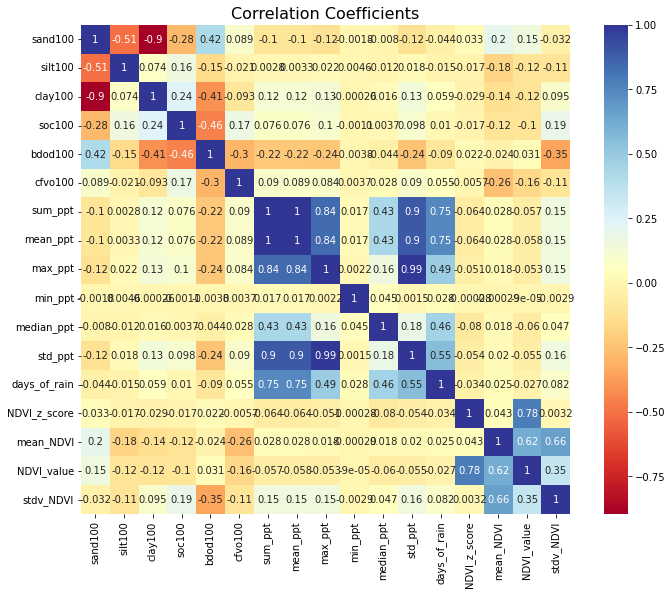

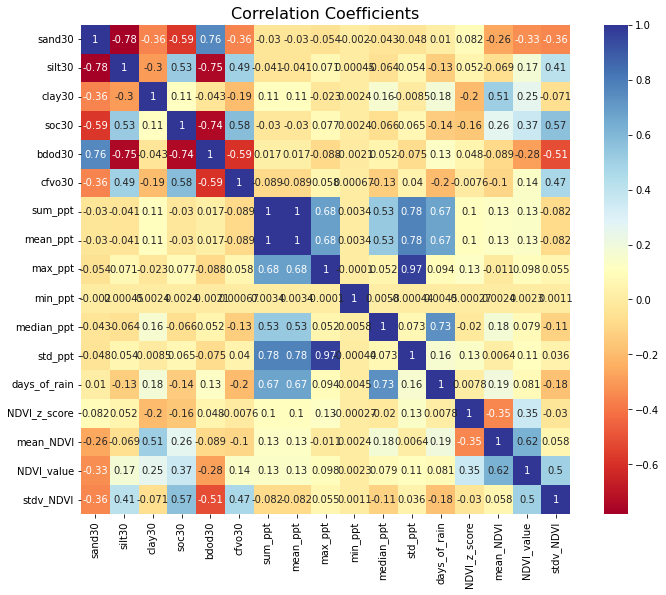

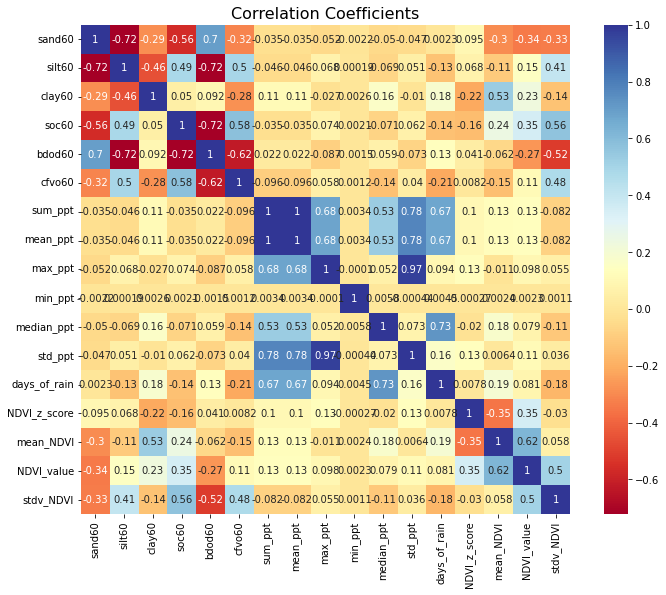

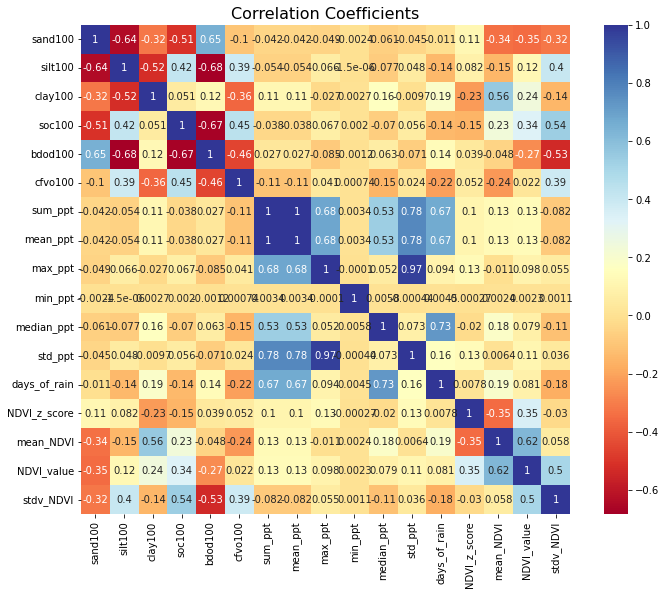

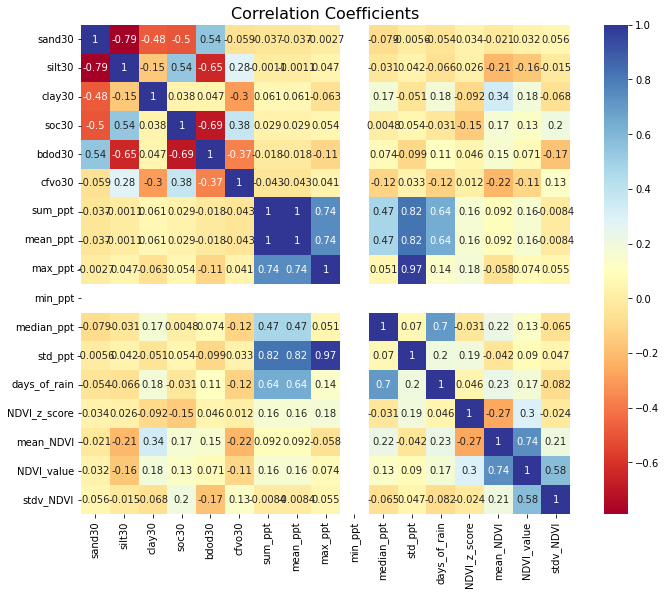

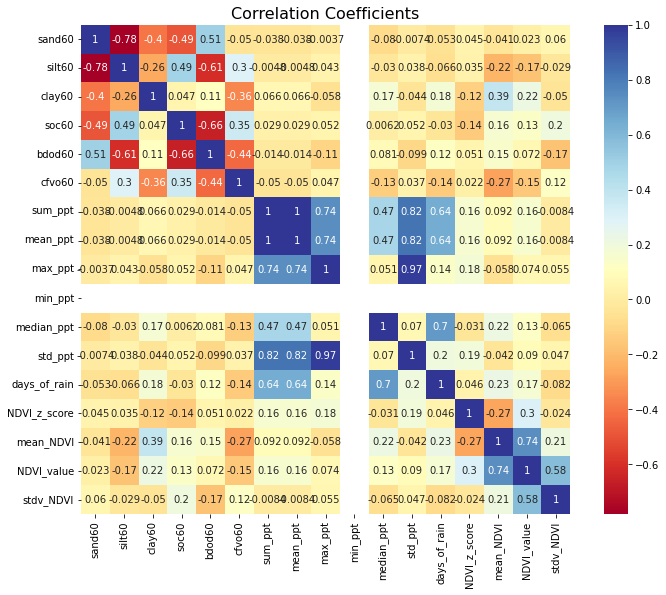

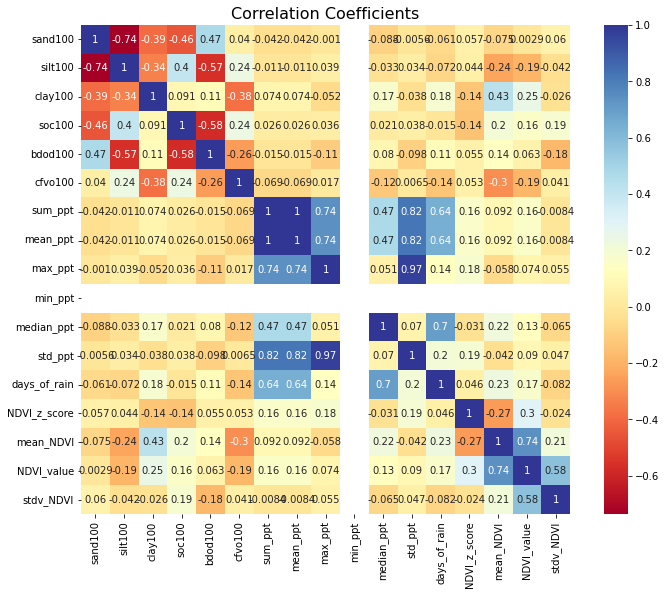

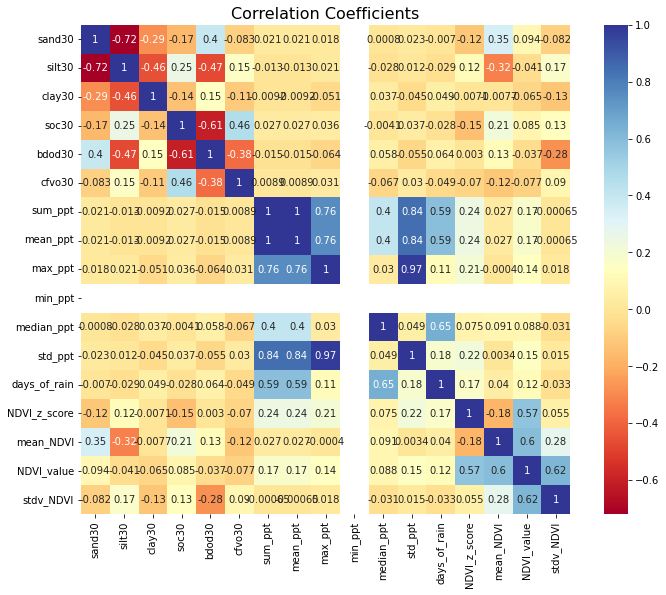

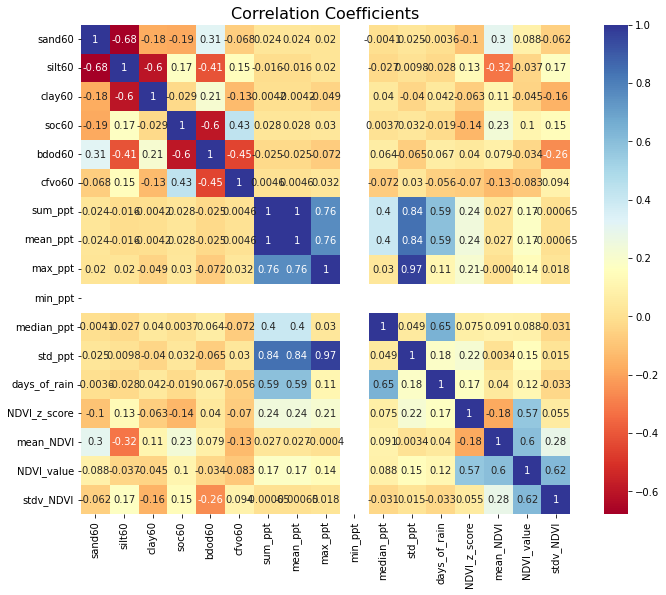

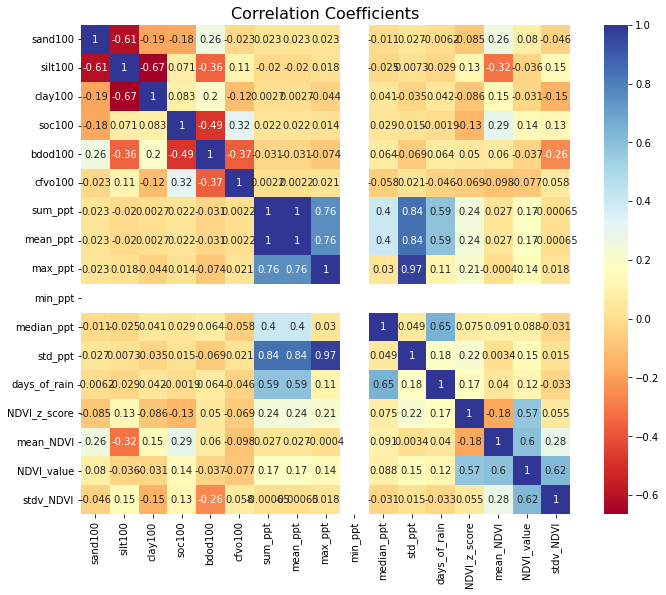

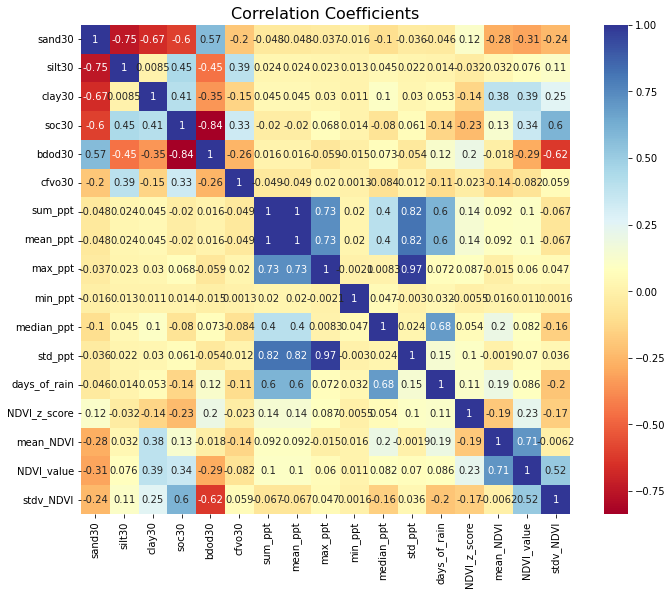

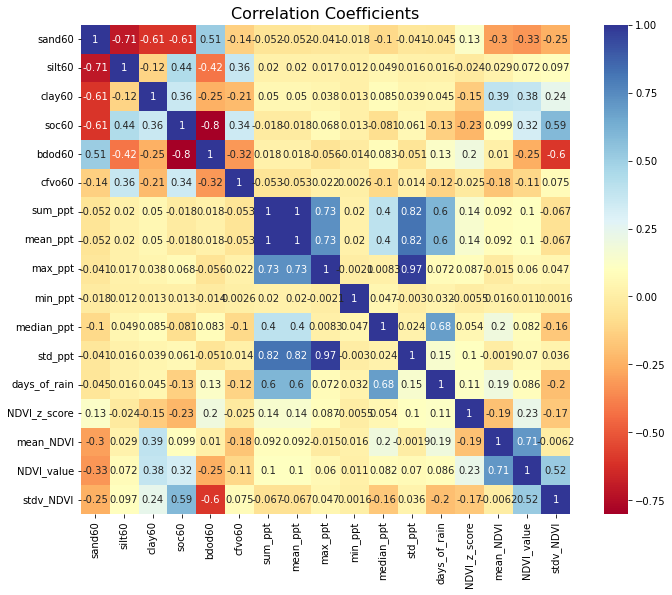

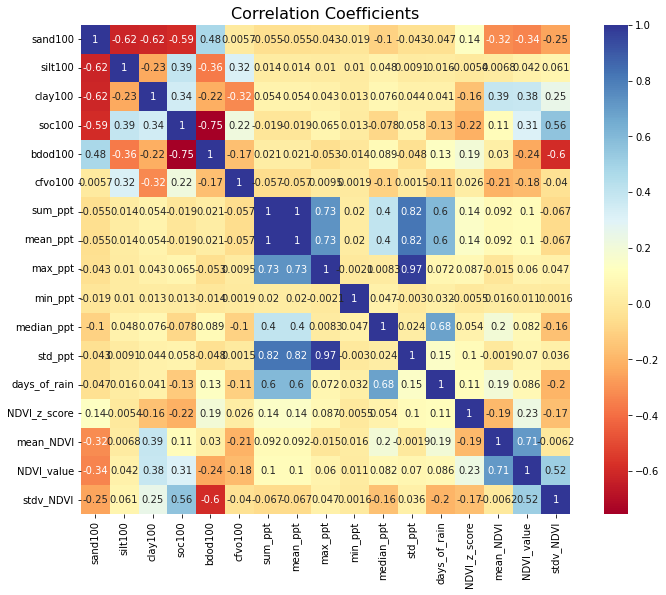

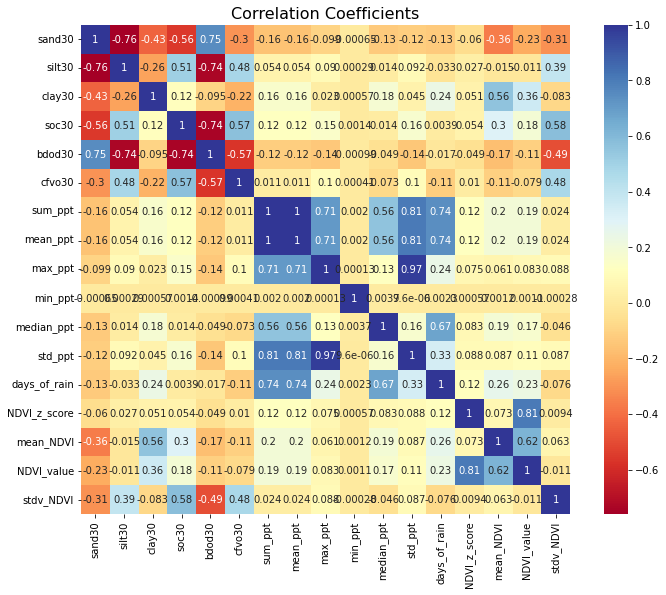

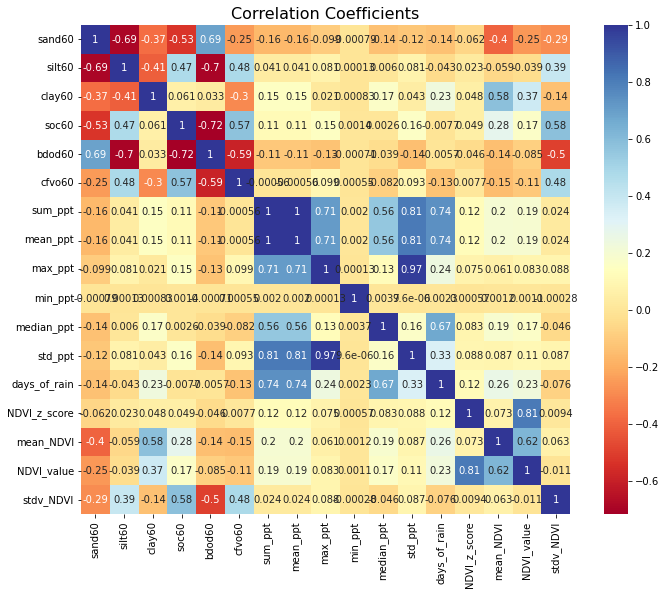

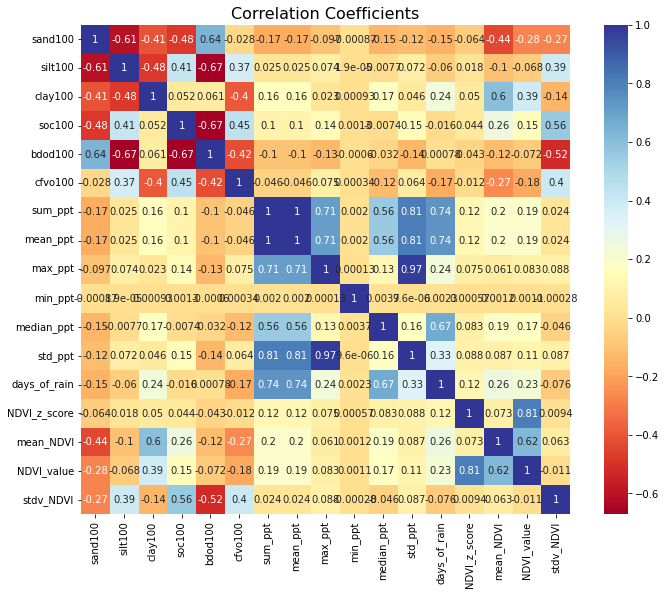

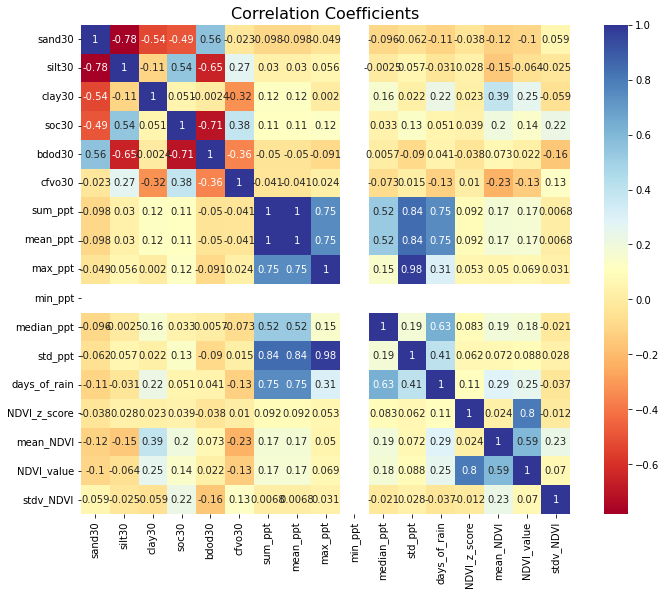

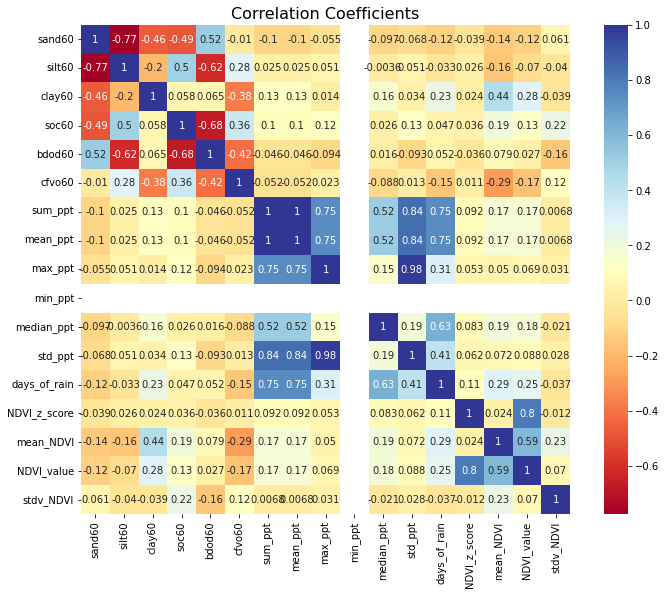

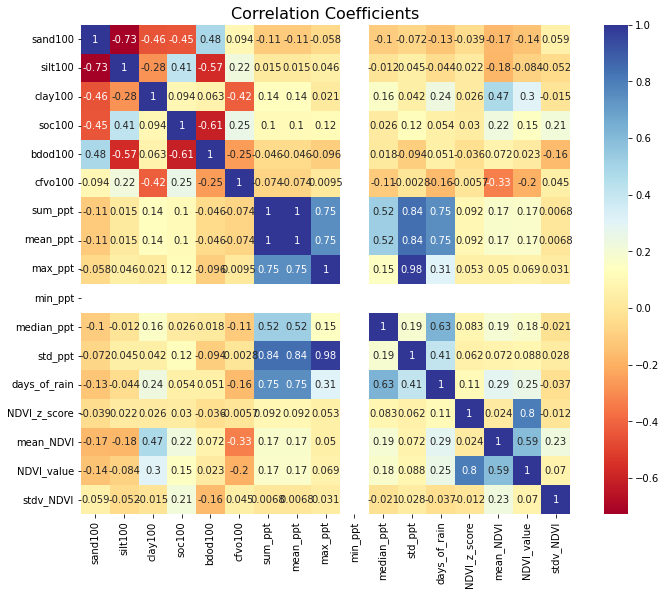

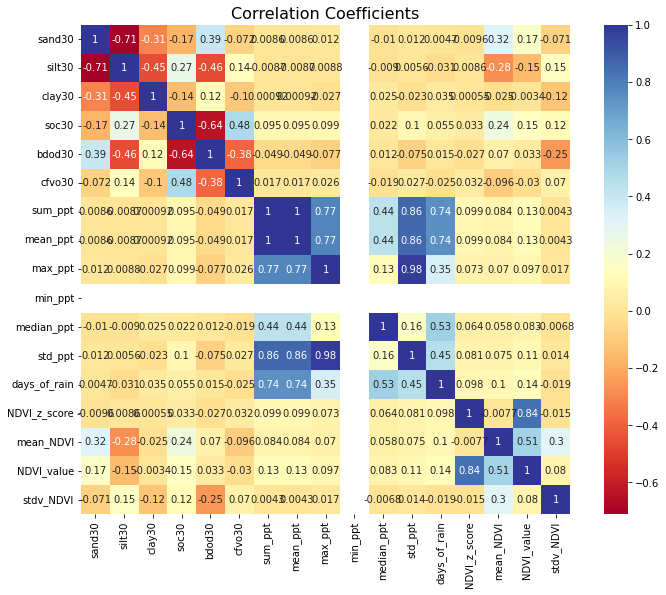

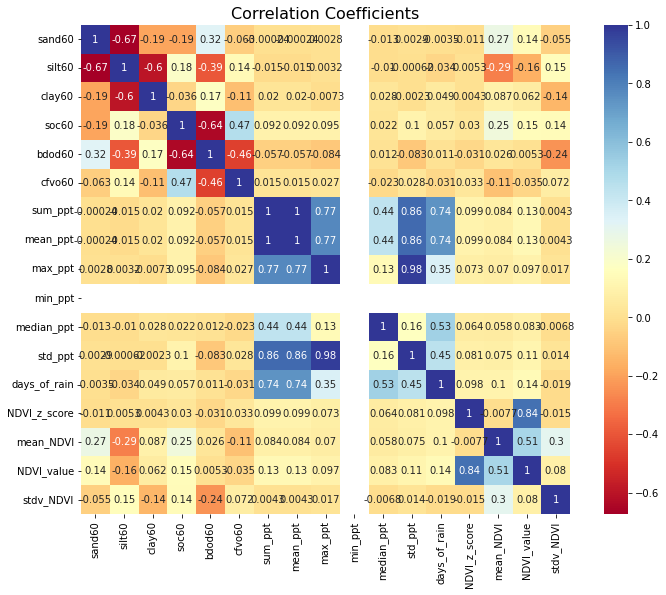

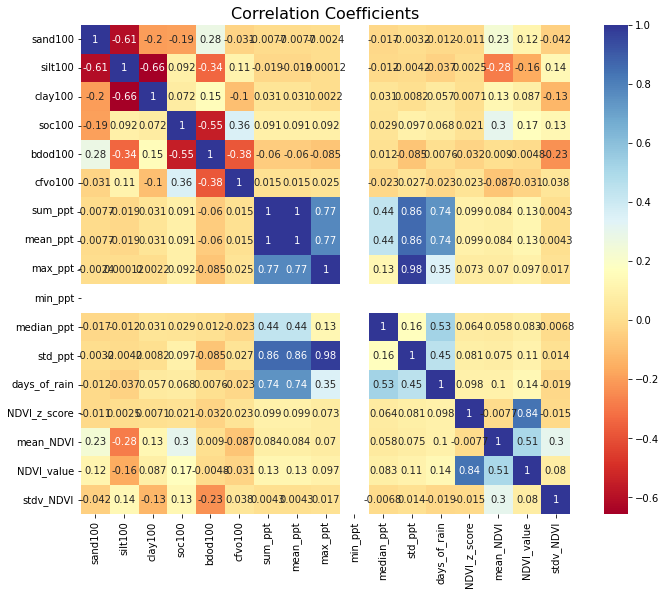

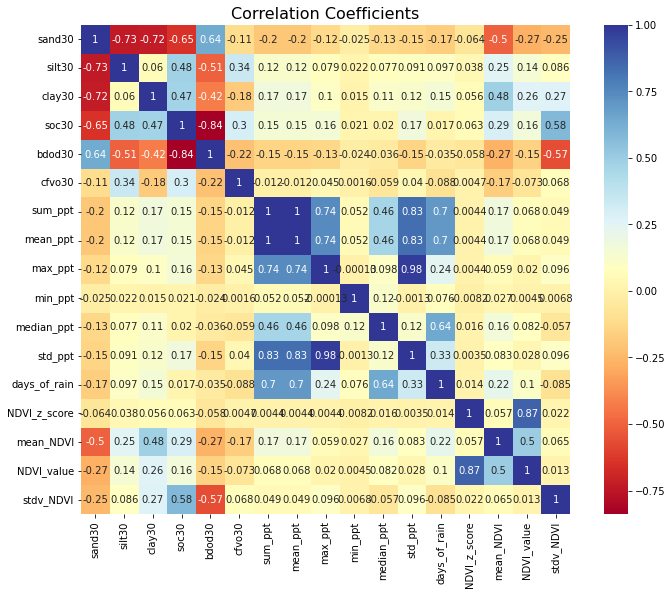

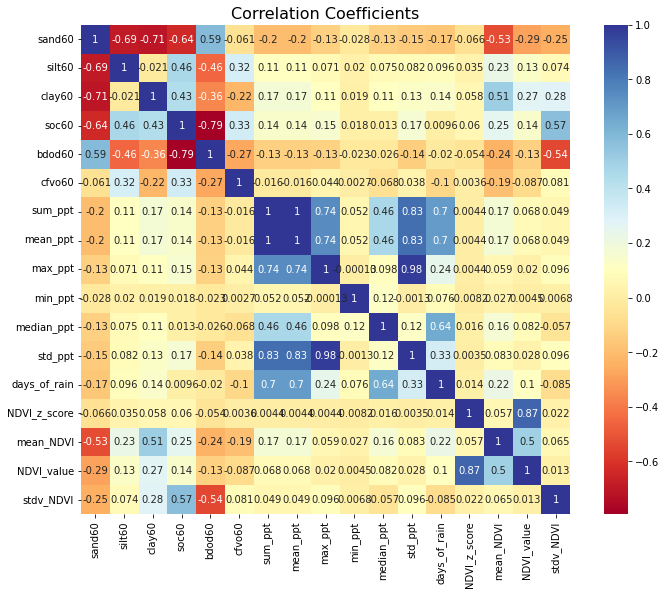

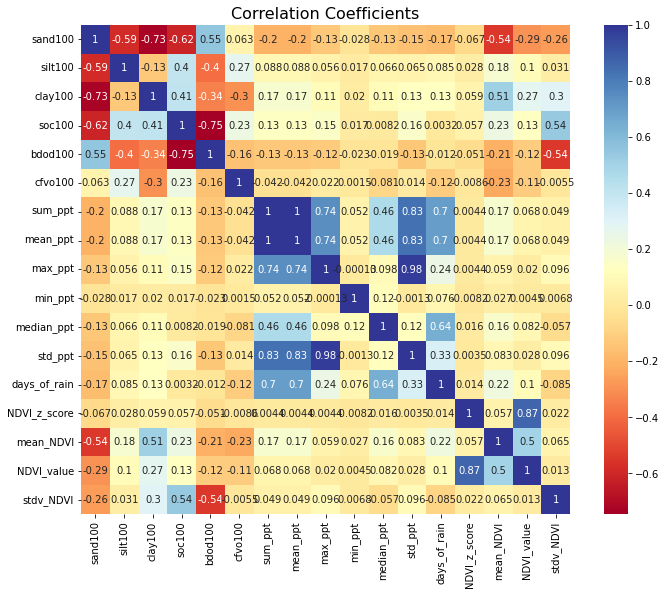

In [184]:
for df in powerset_df:
    plasma = matplotlib.cm.get_cmap("RdYlBu")

    plt.subplots(figsize=(12,9))
    sns.heatmap(df.corr(), annot = True, square=True, cmap = plasma)
    plt.title("Correlation Coefficients", fontsize = 16)
    file_path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\Corr_heatmaps\\z_score_correlations_heatmap" + "_" + df.name + ".jpg"
    plt.savefig(file_path)

## Regression

In [190]:
df100 = [df for df in powerset_df if "100" in df.name]
df100train = [df for df in powerset_df_train if "100" in df.name]
df100test = [df for df in powerset_df_test if "100" in df.name]

rain_dfs_train = [subset_by_rain(df) for df in df100train]
rain_dfs_test = [subset_by_rain(df) for df in df100test]
# df30 = [df for df in powerset_df if "30" in df.name]
# df30train = [df for df in powerset_df_train if "30" in df.name]
# df30test = [df for df in powerset_df_test if "30" in df.name]

In [168]:
rain_dfs_train[1][0].name

't_pos_train_100_grassland_q1_rain'

In [199]:
# pull full profile dfs

# run regression on all datasets
df_scores = {}
df_coeff = {}
for i in range(len(df100train)):
# for df in powerset_all_depths_train: 
    df_train = df100train[i]
    df_test = df100train[i]
    #columns to remove from x
    rm_meX = ["NDVI_z_score", "NDVI_value", "mean_NDVI", "stdv_NDVI", "mean_ppt", "NDVI_dist"]
    
    #drop na values - where dates are in the first 16 days of january 2014
    df_clean_train = df_train.dropna(axis = 0, how = "any")
    #pull out x and y columns 
    data_x_train = df_clean_train[[col for col in df_train.columns if col not in rm_meX]]
    data_y_train = df_clean_train['NDVI_value']
    #scale x and y values 
    scaled_x_train = MinMaxScaler().fit_transform(data_x_train)
    scaled_y_train = MinMaxScaler().fit_transform(data_y_train.array.reshape(-1,1))
    
    #do the same for the test data
    #drop na values - where dates are in the first 16 days of january 2014
    df_clean_test = df_test.dropna(axis = 0, how = "any")
    #pull out x and y columns 
    data_x_test = df_clean_test[[col for col in df_test.columns if col not in rm_meX]]
    data_y_test = df_clean_test['NDVI_value']
    #scale x and y values 
    scaled_x_test = MinMaxScaler().fit_transform(data_x_test)
    scaled_y_test = MinMaxScaler().fit_transform(data_y_test.array.reshape(-1,1))
    
    #run a linear regression on training data
    # bagged estimator
#     reg = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, max_samples =.7, bootstrap_features = True, random_state=0).fit(scaled_x_train, scaled_y_train)
    reg = LinearRegression().fit(scaled_x_train, scaled_y_train)
    
    #save score and coefficients in a dictionary 
    #calculate score based on test data 
    df_scores[df_test.name] = reg.score(scaled_x_test, scaled_y_test)
    df_coeff[df_train.name] = reg.coef_

In [200]:
# pull the scores and sort them to put into a heatmap
scores = []
leftaxis = ["n_big_pos", "n_big_neg", "t_big_pos", "t_big_neg"]
# leftaxis = ["q1", "q2", "q3", "q4"]
# leftaxis = ["nar", "tur"]

for a in leftaxis: 
    a_list = []
    keys = [key for key in list(df_scores.keys()) if a in key]
    for k in keys: 
        a_list.append(df_scores[k])
    scores.append(a_list)

In [201]:
scores

[[0.19850780772197774,
  0.16318848296249577,
  0.08041963932188045,
  0.21260820098042665],
 [0.26273960152978915,
  0.23659344232859147,
  0.2014908901815462,
  0.14742683151787228],
 [0.1364461914982501,
  0.46319936493498837,
  0.5138486943457707,
  0.20009334159066072],
 [0.05077163539945018,
  0.08332659371208573,
  0.07418685371451128,
  0.1525844808075003]]

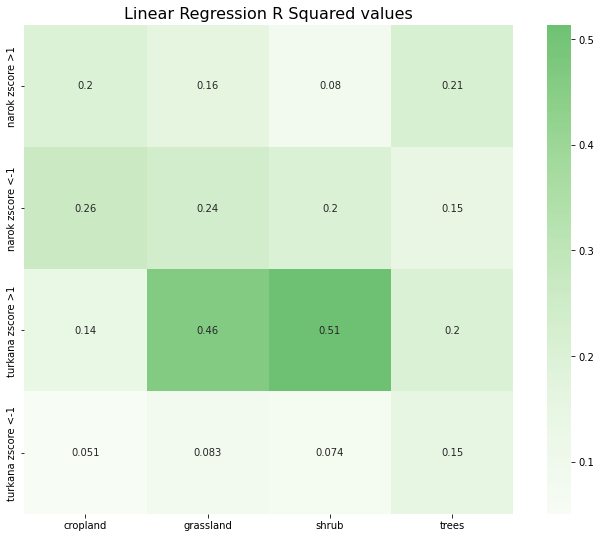

In [202]:
# create regression score heatmap
RdYlGn = matplotlib.cm.get_cmap("RdYlGn")
greens = matplotlib.cm.get_cmap("Greens")
# Yaxes = ['narok', 'narok Q4', 'turkana Q1', 'turkana Q4']
Yaxes = ['narok zscore >1', 'narok zscore <-1', 'turkana zscore >1', 'turkana zscore <-1']
# Yaxes = ['narok', 'turkana']
# Yaxes = ['q1 rain', 'q2 rain', 'q3 rain', 'q4 rain']


Xaxes = ["cropland", "grassland", "shrub", "trees"]

plt.subplots(figsize=(12,9))
sns.heatmap(scores, annot = True, xticklabels = Xaxes, yticklabels = Yaxes, square=True, cmap = greens, center = .5)
plt.title(("Linear Regression R Squared values"), fontsize = 16);
# file_path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\LR_output_full_profile\\rsq_pred_NDVI_zscore_subset_by_BIGzscore.jpg"
# plt.savefig(file_path)

In [203]:
# pull the coefficients and sort them to put into a heatmap
coefficients = []
leftaxis = list(df_coeff.keys())
for a in leftaxis: 
    coefficients.append(list(df_coeff[a].flatten()))

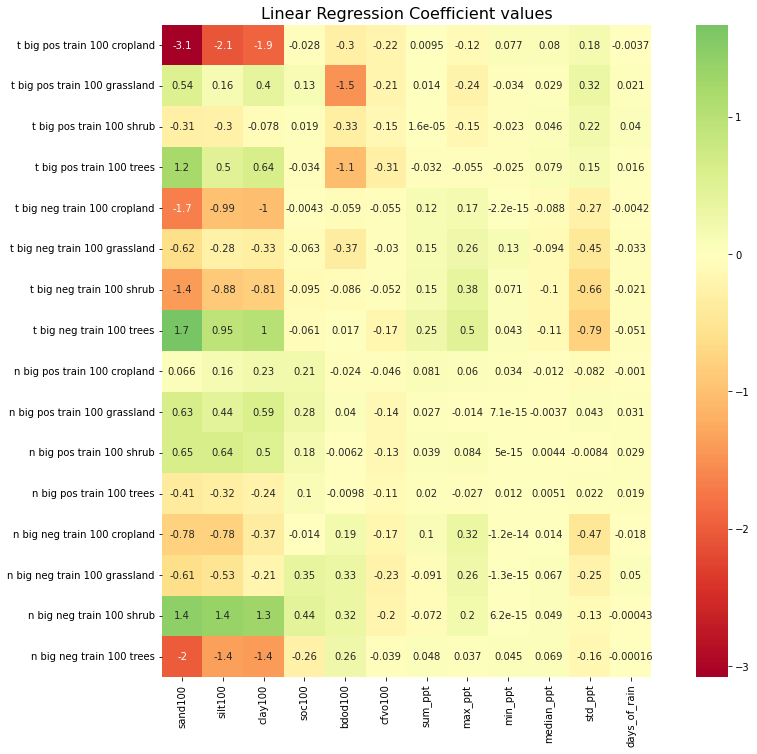

In [204]:
# create regression coefficient heatmap
RdYlGn = matplotlib.cm.get_cmap("RdYlGn")
Yaxes = [col.replace("_", " ") for col in leftaxis]
# Yaxes = [col.replace("train 100 ", "") for col in Yaxes]
Xaxes = ['sand100', 'silt100', 'clay100', 'soc100', 'bdod100', 'cfvo100',
       'sum_ppt', 'max_ppt', 'min_ppt', 'median_ppt', 'std_ppt',
       'days_of_rain']
# Xaxes = ['sand100', 'silt100', 'clay100', 'soc100', 'bdod100', 'cfvo100']

plt.subplots(figsize=(16,12))
sns.heatmap(coefficients, annot = True, xticklabels = Xaxes, yticklabels = Yaxes, square=True, cmap = RdYlGn, center = 0)
plt.title("Linear Regression Coefficient values", fontsize = 16);
# file_path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\coeff_pred_NDVI_zscore_subset_by_BIGzscore.jpg"
# plt.savefig(file_path)

## PCA

In [170]:
## PCA
# run regression on all datasets
df_explained_var_ratio = {}
df_components = {}
for df in powerset_all_depths:
    plot_title = (df.name).replace("_", " ") + " PCA"
    path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\PCA\\" + df.name + "_PCA_z_score_BIG.jpg"

    #drop na values - where dates are in the first 16 days of january 2014
    df_clean = df.dropna(axis = 0, how = "any")
    #scale x and y values 
#     scaled = StandardScaler().fit_transform(df_clean)
#     scaled_features_df = pd.DataFrame(scaled, index=df_clean.index, columns=df_clean.columns)
    
    #run a PCA
    pca = decomposition.PCA(.95)
#     pca.fit(scaled_features_df)
#     projected = pca.fit_transform(scaled_features_df)
    pca.fit(df_clean)
    projected = pca.fit_transform(df_clean)
    
#     plot data
    plt.scatter(projected[:, 0], projected[:, 1],
            c=scaled_features_df.sum_ppt, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('hot_r'))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title(plot_title)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('percent sand content', rotation=270)
    cbar.ax.yaxis.labelpad = 10
    plt.savefig(path)
    plt.close()

    # save output
    df_explained_var_ratio[df.name] = pca.explained_variance_ratio_
    df_components[df.name] = pca.components_

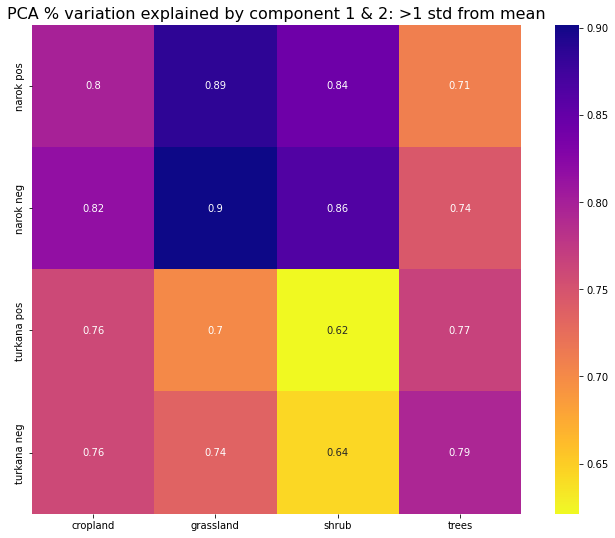

In [171]:
scores = []
all_keys = list(df_explained_var_ratio.keys())
# subsets = ['nar_pos', 'nar_neg', "tur_pos", "tur_neg"]
subsets = ["tur_big_neg", "tur_big_pos", "nar_big_neg", "nar_big_pos"]
for s in subsets:
    subset_scores = []
    keys = [key for key in all_keys if s in key]
    for key in keys: 
        var_1_and_2 = df_explained_var_ratio[key][0] +  df_explained_var_ratio[key][1]
        subset_scores.append(var_1_and_2)
    scores.append(subset_scores)
    
# create regression score heatmap
RdYlGn = matplotlib.cm.get_cmap("RdYlGn")
plasma = matplotlib.cm.get_cmap("plasma_r")
Yaxes = ['narok pos', 'narok neg', "turkana pos", "turkana neg"]
Xaxes = ["cropland", "grassland", "shrub", "trees"]

plt.subplots(figsize=(12,9))
sns.heatmap(scores, annot = True, xticklabels = Xaxes, yticklabels = Yaxes, square=True, cmap = plasma)
plt.title("PCA % variation explained by component 1 & 2: >1 std from mean", fontsize = 16);
file_path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\PCA_var_explained_by_1_2_zscores_LARGE.jpg"
plt.savefig(file_path)

## Old Analysis

In [2]:
tur = pd.read_csv("turkana_raw_w_soils.csv")
nar = pd.read_csv("narok_raw_w_soils.csv")
tur_Q1 = pd.read_csv("Q1_turkana_anomalies.csv")
tur_Q4 = pd.read_csv("Q4_turkana_anomalies.csv")
nar_Q1 = pd.read_csv("Q1_narok_anomalies.csv")
nar_Q4 = pd.read_csv("Q4_narok_anomalies.csv")

In [3]:
tur_Q1.name = "tur_Q1"
tur_Q4.name = "tur_Q4"
nar_Q1.name = "nar_Q1"
nar_Q4.name = "nar_Q4"

In [5]:
# take a sample of turkana and merge soil and lulc data 
def sample_and_merge(df_to_sample, df_to_merge, n):
    df_to_merge_cols = df_to_merge[["Unnamed: 0", 'sand30', 'sand60', 'sand100',
       'silt30', 'silt60', 'silt100', 'clay30', 'clay60', 'clay100', 'soc30',
       'soc60', 'soc100', 'bdod30', 'bdod60', 'bdod100', 'cfvo30', 'cfvo60',
       'cfvo100', 'cropland','grassland', 'shrub', 'trees']]
    df_sampled = df_to_sample.sample(n = n)
    df_merged = df_sampled.merge(df_to_merge_cols, how = "left", left_on = "point_index", right_on = "Unnamed: 0")
    df_merged.name = df_to_sample.name
    
    return (df_merged)

In [46]:
# create datasets - 48 in total 
#base sets are samples and merged anomaly sets
# train test split Q1
t_trainQ1, t_testQ1 = train_test_split(tur_Q1, test_size = .2)
n_trainQ1, n_testQ1 = train_test_split(nar_Q1, test_size = .2)


# train test split Q4
t_trainQ4, t_testQ4 = train_test_split(tur_Q4, test_size = .2)
n_trainQ4, n_testQ4 = train_test_split(nar_Q4, test_size = .2)

# name dataframes
t_trainQ1.name = "tur_Q1_train"
t_testQ1.name = "tur_Q1_test"
n_trainQ1.name = "nar_Q1_train"
n_testQ1.name = "nar_Q1_test"
t_trainQ4.name = "tur_Q4_train"
t_testQ4.name = "tur_Q4_test"
n_trainQ4.name = "nar_Q4_train"
n_testQ4.name = "nar_Q4_test"

#use the full set
base_sets = [sample_and_merge(tur_Q1, tur, len(tur_Q1)), sample_and_merge(tur_Q4, tur, len(tur_Q4)), sample_and_merge(nar_Q1, nar, len(nar_Q1)), sample_and_merge(nar_Q4, nar, len(nar_Q4))]
#create train and test sets for the regression
train_sets = [sample_and_merge(t_trainQ1, tur, len(t_trainQ1)), sample_and_merge(t_trainQ4, tur, len(t_trainQ4)), sample_and_merge(n_trainQ1, nar, len(n_trainQ1)), sample_and_merge(n_trainQ4, nar, len(n_trainQ4))]
test_sets = [sample_and_merge(t_testQ1, tur, len(t_testQ1)), sample_and_merge(t_testQ4, tur, len(t_testQ4)), sample_and_merge(n_testQ1, nar, len(n_testQ1)), sample_and_merge(n_testQ4, nar, len(n_testQ4))]

# sample the full sets
# base_sets = [sample_and_merge(tur_Q1, tur, 10000), sample_and_merge(tur_Q4, tur, 10000), sample_and_merge(nar_Q1, nar, 10000), sample_and_merge(nar_Q4, nar, 10000)]

#soil variable depths to consider
depths = ["30", '60', '100']
# land use to consider
lulc = ['cropland','grassland', 'shrub', 'trees']

#dictionary of dataframe name and dataframe - FULL DATA
def get_dataframes(base_sets):
    powerset_df = []
    powerset_all_depths = []
    for df in base_sets:
        for l in lulc:
            minus_lulc_cols = [col for col in df.columns if col not in lulc]
            lulc_name = (df.name + "_"+ l)
            lulc_df = df[df[l]>0][minus_lulc_cols]
            lulc_df.name = lulc_name
            powerset_all_depths.append(lulc_df)

            for depth in depths: 
                outdf_name = (df.name +"_"+ depth +"_"+ l)
                #pull appropriate soil columns
                select_cols = [col for col in df.columns if depth in col]
                #add back other columns needed
                select_cols.extend(['anomaly_value', '16dayppt_before_date'])
                #subset the original dataframe
                good2go = df[df[l]>0][select_cols]
                good2go.name = outdf_name
                powerset_df.append(good2go)
                
    return (powerset_df, powerset_all_depths)

# get full datasets
powerset_df, powerset_all_depths = get_dataframes(base_sets)
# get train and test datasets
powerset_df_train, powerset_all_depths_train = get_dataframes(train_sets)
powerset_df_test, powerset_all_depths_test = get_dataframes(test_sets)

In [77]:
## PCA
# run regression on all datasets
df_explained_var_ratio = {}
df_components = {}
for df in powerset_all_depths:
    plot_title = (df.name).replace("_", " ") + " PCA"
    path = "C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\PCA\\" + df.name + "_PCA_ppt.jpg"
    #columns to remove from x
    rm_meX = ['point_index','anomaly_date', 'Unnamed: 0']

    #drop na values - where dates are in the first 16 days of january 2014
    df_clean = df.dropna(axis = 0, how = "any")
    #pull out x and y columns 
    data = df_clean[[col for col in df.columns if col not in rm_meX]]
    #scale x and y values 
    scaled = MinMaxScaler().fit_transform(data)
    scaled_features_df = pd.DataFrame(scaled, index=data.index, columns=data.columns)

    #run a PCA
    pca = decomposition.PCA(.95)
    pca.fit(scaled_features_df)
    projected = pca.fit_transform(scaled_features_df)

    plt.scatter(projected[:, 0], projected[:, 1],
            c=scaled_features_df.sand100, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('hot_r'))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title(plot_title)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('percent sand content', rotation=270)
    cbar.ax.yaxis.labelpad = 10
    plt.savefig(path)
    plt.close()

    # save output
    df_explained_var_ratio[df.name] = pca.explained_variance_ratio_
    df_components[df.name] = pca.components_

In [87]:
 df_explained_var_ratio["tur_Q1_cropland"][0]

0.4280184847387014

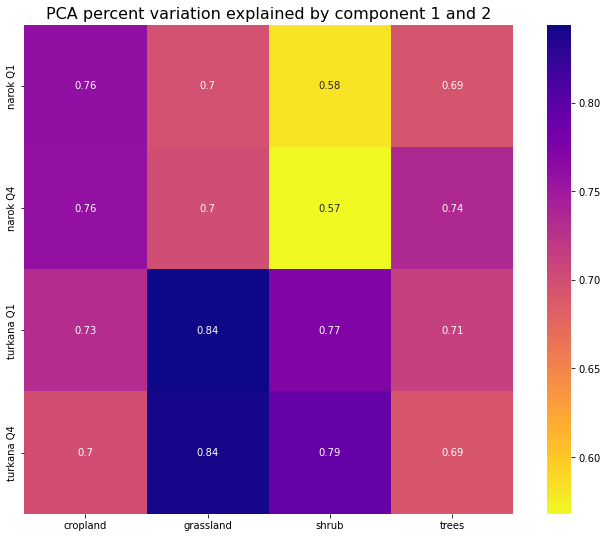

In [91]:
scores = []
all_keys = list(df_explained_var_ratio.keys())
subsets = ['nar_Q1', 'nar_Q4', 'tur_Q1', 'tur_Q4']
for s in subsets:
    subset_scores = []
    keys = [key for key in all_keys if s in key]
    for key in keys: 
        var_1_and_2 = df_explained_var_ratio[key][0] +  df_explained_var_ratio[key][1]
        subset_scores.append(var_1_and_2)
    scores.append(subset_scores)
    
# create regression score heatmap
RdYlGn = matplotlib.cm.get_cmap("RdYlGn")
plasma = matplotlib.cm.get_cmap("plasma_r")
Yaxes = ['narok Q1', 'narok Q4', 'turkana Q1', 'turkana Q4']
Xaxes = ["cropland", "grassland", "shrub", "trees"]

plt.subplots(figsize=(12,9))
sns.heatmap(scores, annot = True, xticklabels = Xaxes, yticklabels = Yaxes, square=True, cmap = plasma)
plt.title("PCA percent variation explained by component 1 and 2", fontsize = 16);
file_path = "C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\PCA_var_explained_by_1_2.jpg"
plt.savefig(file_path)

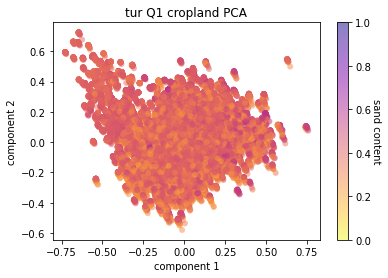

In [100]:
df = powerset_all_depths[0]
plot_title = (df.name).replace("_", " ") + " PCA"
path = "C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\PCA\\" + df.name + "_PCA.jpg"
#columns to remove from x
rm_meX = ['point_index','anomaly_date', 'Unnamed: 0']

#drop na values - where dates are in the first 16 days of january 2014
df_clean = df.dropna(axis = 0, how = "any")
#pull out x and y columns 
data = df_clean[[col for col in df.columns if col not in rm_meX]]
#scale x and y values 
scaled = MinMaxScaler().fit_transform(data)
scaled_features_df = pd.DataFrame(scaled, index=data.index, columns=data.columns)

#run a PCA
pca = decomposition.PCA(.95)
pca.fit(scaled_features_df)
projected = pca.fit_transform(scaled_features_df)

plt.scatter(projected[:, 2], projected[:, 3],
        c=scaled_features_df["anomaly_value"], edgecolor='none', alpha=0.5,
        cmap=plt.cm.get_cmap('plasma_r'))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title(plot_title)
cbar = plt.colorbar()
cbar.ax.set_ylabel('sand content', rotation=270)
cbar.ax.yaxis.labelpad = 10


In [95]:
powerset_all_depths[0].columns

Index(['point_index', 'anomaly_date', 'anomaly_value', '16dayppt_before_date',
       'Unnamed: 0', 'sand30', 'sand60', 'sand100', 'silt30', 'silt60',
       'silt100', 'clay30', 'clay60', 'clay100', 'soc30', 'soc60', 'soc100',
       'bdod30', 'bdod60', 'bdod100', 'cfvo30', 'cfvo60', 'cfvo100'],
      dtype='object')